Initializations, run once per runtime

In [1]:
import firebase_admin
from firebase_admin import credentials, db, firestore
import os

# Use the downloaded JSON key file
cred = credentials.Certificate("yoruba-dictionary-5cdea-firebase-adminsdk-fbsvc-970df882b3.json")

# Initialize Firebase with credentials
firebase_admin.initialize_app(cred)

# Access Firestore
firestore_db = firestore.client()

In [2]:
def grabAudio(syllable):
  doc_ref = firestore_db.collection("syllableaudio").document(syllable)
  doc = doc_ref.get()
  if doc.exists:
    return doc.to_dict()
  else:
    return None

In [3]:
for entry in grabAudio('a').items():
  print(entry)

('18', b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2\x81\x04B\xf3\x81\x08B\x82\x84webmB\x87\x81\x04B\x85\x81\x02\x18S\x80g\x01\x00\x00\x00\x00\x00+\xfe\x11M\x9bt\xbaM\xbb\x8bS\xab\x84\x15I\xa9fS\xac\x81\xa1M\xbb\x8bS\xab\x84\x16T\xaekS\xac\x81\xd6M\xbb\x8cS\xab\x84\x12T\xc3gS\xac\x82\x01@M\xbb\x8cS\xab\x84\x1cS\xbbkS\xac\x82+\xe8\xec\x01\x00\x00\x00\x00\x00\x00Y\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x15I\xa9f\xb0*\xd7\xb1\x83\x0fB@M\x80\x8cLavf62.0.100WA\x8cLavf62.0.100D\x89\x88@\x91\x00\x00\x00\x00\x00\x00\x16T\xaek\xe5\xae\x01\x00\x00\x00\x00\x00\x00\\\xd7\x81\x01s\xc5\x88jE\x13\x14\xae\x85\xf7\x1d\x9c\x81\x00"\xb5\x9c\x83und\x88\x81\x00\x86\x86A_OPUSV\xaa\x83c.\xa0V

Listen to some of the audio files

In [20]:
import random
from playsound import playsound
from IPython.display import Audio, display

def play_random_audio(syllable):
  syllable = random.choice(list(grabAudio(syllable).values()))

  with open(f'grabbed.webm', "wb") as f:
        f.write(syllable)

  display(Audio('grabbed.webm', autoplay=True))

play_random_audio('a')
play_random_audio('a')
play_random_audio('e')
play_random_audio('e')
play_random_audio('o')
play_random_audio('u')

In [5]:
from pydub import AudioSegment
import numpy as np
import io

def convert_webm_to_raw(webm_data: bytes) -> np.ndarray:
    """
    Converts WebM audio data (bytestring) to raw audio data (NumPy array).

    Args:
        webm_data: The WebM audio data as a byte string.

    Returns:
        A NumPy array representing the raw audio data.  Handles errors.
    """
    try:
        # Create an in-memory file-like object from the WebM data
        audio_segment = AudioSegment.from_file(io.BytesIO(webm_data), format="webm")
        # Get raw audio data as a NumPy array of floats.  Important to use float32.
        raw_audio_data = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)
        return raw_audio_data
    except Exception as e:
        print(f"Error converting WebM data: {e}")
        return np.array([], dtype=np.float32) # Return an empty array on error

In [6]:
simplification_chart = {
    "a" : 'a',
    "á" : 'a',
    "à" : 'a',
    "e" : 'e',
    "é" : 'e',
    "è": 'e',
    "ẹ": 'e',
    "ẹ́": 'e',
    "ẹ̀" : 'e',
    "i": 'i',
    "í" : 'i',
    "ì": 'i',
    "o": 'o',
    "ó" : 'o',
    "ò" : 'o',
    "ọ": 'o',
    "ọ́": 'o',
    "ọ̀" : 'o',
    "u": 'u',
    "ú" : 'u',
    "ù" : 'u',
}

def syllable_simplifyer(syllable):
  if syllable in simplification_chart:
    return simplification_chart[syllable]
  else:
    return syllable

print(syllable_simplifyer('ẹ̀')) # 'e'

def syllable_version_finder(syllable):
  syllable_look = syllable_simplifyer(syllable)
  return [syl for (syl, val) in simplification_chart.items() if val == syllable_look]

print(syllable_version_finder('ẹ')) # All 6 e versions

e
['e', 'é', 'è', 'ẹ', 'ẹ́', 'ẹ̀']


In [7]:
def compileDatasets(syllables, separation = 0.8):
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  found_data = False  # Track if any data is found
  random.seed(10)

  for syllable in syllables:
    for version in syllable_version_finder(syllable):
      # print(f"Processing syllable: {version}")
      labeled_syllable = syllable_simplifyer(version) # Makes sure label is the overall vowel
      audio_data_dict = grabAudio(labeled_syllable)

      if audio_data_dict:
        found_data = True
        # print(f"Found audio data for syllable: {len(list(audio_data_dict.items()))}")
        for audio_label, webm_data in audio_data_dict.items():
          raw_audio = convert_webm_to_raw(webm_data)
          if len(raw_audio) > 0:
            if random.random() <= separation:
              x_train.append(raw_audio)
              y_train.append(labeled_syllable)
            else:
              x_test.append(raw_audio)
              y_test.append(labeled_syllable)
          else:
            print(f"No valid audio data found for label: {syllable} : {audio_label}")
      else:
            print(f"No audio data found for syllable: {syllable}")

  if not found_data:
      raise ValueError("No audio data found for any of the provided syllables.  Check your Firestore database.")
  return x_train, y_train, x_test, y_test

In [8]:
syllables_to_process = ['a', 'e', 'i', 'o', 'u', 'ń']
audio_data, labels, audio_test, labels_test = compileDatasets(syllables_to_process)

# Print some of the data to verify
print("Number of labels:", len(labels))
print("Number of audio samples:", len(audio_data))

Number of labels: 307
Number of audio samples: 307


In [9]:
def numpy_pad_sequences(sequences, dtype, maxlen = None, padding = 'post',
                       truncating = 'post', value = 0.0) -> np.ndarray:
    """
    Pads a list of NumPy arrays to a specified length using NumPy.

    This function is intended to replicate the behavior of tf.keras.preprocessing.sequence.pad_sequences,
    but without requiring TensorFlow. Isn't supported in Python 3.13, my local version of Python

    Args:
        sequences: A list of NumPy arrays, where each array represents a sequence to be padded.
                   All arrays are assumed to have the same dtype.
        maxlen: Maximum length of the padded sequences. If None, the length of the longest
            sequence is used.
        padding: String, 'pre' or 'post' (default 'post').
            Pad before or after each sequence.
        truncating: String, 'pre' or 'post' (default 'post').
            Remove values from sequences larger than maxlen, either at the beginning or at the end
            of the sequences.
        value: Float or Int, value to pad the sequences to the desired value.

    Returns:
        A NumPy array of shape (len(sequences), maxlen) if maxlen is provided or
        (len(sequences), max(len(s) for s in sequences)) otherwise.
        The dtype of the output array is the same as the dtype of the input sequences.
        If the input sequences have different dtypes, the function will raise a ValueError.
    """
    # Check that the padding and truncating values are valid
    if padding not in ('pre', 'post'):
        raise ValueError('Padding type must be either "pre" or "post"')
    if truncating not in ('pre', 'post'):
        raise ValueError('Truncating type must be either "pre" or "post"')

    # Determine the maximum length
    if maxlen is None:
        maxlen = max(len(s) for s in sequences)

    # Create the output array
    output_array = np.full((len(sequences), maxlen), value, dtype=dtype)

    # Pad and truncate each sequence
    for i, sequence in enumerate(sequences):
        seq_len = len(sequence)

        if seq_len < maxlen:
            # Padding is needed
            if padding == 'pre':
                output_array[i, :seq_len] = sequence
            else:  # padding == 'post'
                output_array[i, -seq_len:] = sequence
        elif seq_len > maxlen:
            # Truncating is needed
            if truncating == 'pre':
                output_array[i, :] = sequence[-maxlen:]
            else:  # truncating == 'post'
                output_array[i, :] = sequence[:maxlen]
        else:
            # No padding or truncating needed
            output_array[i, :] = sequence

    return output_array

In [10]:
# Our data is collected, but the audio data has different lengths! Add padding
max_length = max(len(sample) for sample in audio_data)
padded_audio_data = numpy_pad_sequences(
    audio_data,
    dtype='float32',
    maxlen=max_length,  # Use the maximum length
    padding='post',  # 'pre' or 'post'
)
print("Padded data shape:", padded_audio_data.shape)
audio_data = padded_audio_data

Padded data shape: (307, 95040)


In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch import nn

# Load data to device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move data to device
train_tensor = torch.tensor(audio_data, dtype=torch.float32).to(device)

# Labels need to be encoded into numbers, using sklearn to do it (AI to develop AI lol)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_train_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# Create a Dataset and DataLoader
train_dataset = TensorDataset(train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=int(len(train_dataset)/4), shuffle=False)

In [ ]:
from tqdm import tqdm

class NeuralNetworkPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(NeuralNetworkPyTorch, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size_1)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        return x

def train(model, optimizer, criterion_mle, train_loader, n_epochs, lmbda, device, model_dir, save_every = 100,):
    costs = []
    model.train()

    os.makedirs(model_dir, exist_ok=True)

    for epoch in range(n_epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", unit="batch"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)

            # Compute MLE loss
            loss_mle = criterion_mle(outputs, y_batch)
            # print(f"Loss MLE: {loss_mle.item()}")  # Print the MLE loss

            # Compute L1 regularization penalty
            l1_penalty = 0.0
            for param in model.parameters():
                l1_penalty += torch.norm(param, p=1)

            loss = loss_mle + lmbda * l1_penalty / X_batch.size(0)
            # print(f"Total Loss: {loss.item()}")

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy for this batch
            _, predicted_classes = torch.max(outputs, 1)  # Get class predictions
            correct_predictions += (predicted_classes == y_batch).sum().item()
            total_samples += y_batch.size(0)

        epoch_loss = total_loss / len(train_loader)
        costs.append(epoch_loss)
        epoch_accuracy = correct_predictions / total_samples
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the model every save_every epochs
        if (epoch + 1) % save_every == 0:
            model_path = os.path.join(model_dir, f"model_epoch_{epoch + 1}.pth")
            torch.save(model.state_dict(), model_path)
            print(f"Saved model at epoch {epoch + 1} to {model_path}")

    model.eval()
    return costs

In [13]:
# Hyperparameters for training
input_size = padded_audio_data.shape[1]
print(input_size)
hidden_size = 500
output_size = len(np.unique(y_encoded))
print(output_size)
learning_rate = 0.001
lmbda = 0.0001
n_epochs = 50

pytorch_model = NeuralNetworkPyTorch(input_size, hidden_size, hidden_size * 2, 100, output_size).to(device)

optimizer = torch.optim.SGD(pytorch_model.parameters(), lr=learning_rate)
criterion_mle = nn.CrossEntropyLoss()

95040
5


In [14]:
costs = train(pytorch_model, optimizer, criterion_mle, train_loader, n_epochs, lmbda, device, "models", 10)

Epoch 1/50: 100%|██████████| 5/5 [00:01<00:00,  4.39batch/s]


Epoch [1/50], Loss: 2379109.1805, Accuracy: 0.1596


Epoch 2/50: 100%|██████████| 5/5 [00:01<00:00,  4.18batch/s]


Epoch [2/50], Loss: 330859.7275, Accuracy: 0.6612


Epoch 3/50: 100%|██████████| 5/5 [00:01<00:00,  4.20batch/s]


Epoch [3/50], Loss: 18003.5776, Accuracy: 0.9479


Epoch 4/50: 100%|██████████| 5/5 [00:01<00:00,  4.13batch/s]


Epoch [4/50], Loss: 5147.2385, Accuracy: 0.9707


Epoch 5/50: 100%|██████████| 5/5 [00:01<00:00,  4.25batch/s]


Epoch [5/50], Loss: 0.6913, Accuracy: 1.0000


Epoch 6/50: 100%|██████████| 5/5 [00:01<00:00,  4.05batch/s]


Epoch [6/50], Loss: 0.6913, Accuracy: 1.0000


Epoch 7/50: 100%|██████████| 5/5 [00:01<00:00,  4.20batch/s]


Epoch [7/50], Loss: 0.6913, Accuracy: 1.0000


Epoch 8/50: 100%|██████████| 5/5 [00:01<00:00,  4.38batch/s]


Epoch [8/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 9/50: 100%|██████████| 5/5 [00:01<00:00,  4.24batch/s]


Epoch [9/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 10/50: 100%|██████████| 5/5 [00:01<00:00,  4.43batch/s]


Epoch [10/50], Loss: 0.6912, Accuracy: 1.0000
Saved model at epoch 10 to models\model_epoch_10.pth


Epoch 11/50: 100%|██████████| 5/5 [00:01<00:00,  4.24batch/s]


Epoch [11/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 12/50: 100%|██████████| 5/5 [00:01<00:00,  4.38batch/s]


Epoch [12/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 13/50: 100%|██████████| 5/5 [00:01<00:00,  4.44batch/s]


Epoch [13/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 14/50: 100%|██████████| 5/5 [00:01<00:00,  4.38batch/s]


Epoch [14/50], Loss: 0.6912, Accuracy: 1.0000


Epoch 15/50: 100%|██████████| 5/5 [00:01<00:00,  4.41batch/s]


Epoch [15/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 16/50: 100%|██████████| 5/5 [00:01<00:00,  4.28batch/s]


Epoch [16/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 17/50: 100%|██████████| 5/5 [00:01<00:00,  4.29batch/s]


Epoch [17/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 18/50: 100%|██████████| 5/5 [00:01<00:00,  4.39batch/s]


Epoch [18/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 19/50: 100%|██████████| 5/5 [00:01<00:00,  4.34batch/s]


Epoch [19/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 20/50: 100%|██████████| 5/5 [00:01<00:00,  4.52batch/s]


Epoch [20/50], Loss: 0.6911, Accuracy: 1.0000
Saved model at epoch 20 to models\model_epoch_20.pth


Epoch 21/50: 100%|██████████| 5/5 [00:01<00:00,  4.40batch/s]


Epoch [21/50], Loss: 0.6911, Accuracy: 1.0000


Epoch 22/50: 100%|██████████| 5/5 [00:01<00:00,  4.29batch/s]


Epoch [22/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 23/50: 100%|██████████| 5/5 [00:01<00:00,  4.37batch/s]


Epoch [23/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 24/50: 100%|██████████| 5/5 [00:01<00:00,  4.33batch/s]


Epoch [24/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 25/50: 100%|██████████| 5/5 [00:01<00:00,  4.54batch/s]


Epoch [25/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 26/50: 100%|██████████| 5/5 [00:01<00:00,  4.56batch/s]


Epoch [26/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 27/50: 100%|██████████| 5/5 [00:01<00:00,  4.56batch/s]


Epoch [27/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 28/50: 100%|██████████| 5/5 [00:01<00:00,  4.49batch/s]


Epoch [28/50], Loss: 0.6910, Accuracy: 1.0000


Epoch 29/50: 100%|██████████| 5/5 [00:01<00:00,  4.41batch/s]


Epoch [29/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 30/50: 100%|██████████| 5/5 [00:01<00:00,  4.46batch/s]


Epoch [30/50], Loss: 0.6909, Accuracy: 1.0000
Saved model at epoch 30 to models\model_epoch_30.pth


Epoch 31/50: 100%|██████████| 5/5 [00:01<00:00,  4.42batch/s]


Epoch [31/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 32/50: 100%|██████████| 5/5 [00:01<00:00,  4.48batch/s]


Epoch [32/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 33/50: 100%|██████████| 5/5 [00:01<00:00,  4.41batch/s]


Epoch [33/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 34/50: 100%|██████████| 5/5 [00:01<00:00,  4.48batch/s]


Epoch [34/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 35/50: 100%|██████████| 5/5 [00:01<00:00,  4.52batch/s]


Epoch [35/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 36/50: 100%|██████████| 5/5 [00:01<00:00,  4.37batch/s]


Epoch [36/50], Loss: 0.6909, Accuracy: 1.0000


Epoch 37/50: 100%|██████████| 5/5 [00:01<00:00,  4.33batch/s]


Epoch [37/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 38/50: 100%|██████████| 5/5 [00:01<00:00,  4.37batch/s]


Epoch [38/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 39/50: 100%|██████████| 5/5 [00:01<00:00,  4.36batch/s]


Epoch [39/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 40/50: 100%|██████████| 5/5 [00:01<00:00,  4.40batch/s]


Epoch [40/50], Loss: 0.6908, Accuracy: 1.0000
Saved model at epoch 40 to models\model_epoch_40.pth


Epoch 41/50: 100%|██████████| 5/5 [00:01<00:00,  4.48batch/s]


Epoch [41/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 42/50: 100%|██████████| 5/5 [00:01<00:00,  4.29batch/s]


Epoch [42/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 43/50: 100%|██████████| 5/5 [00:01<00:00,  4.28batch/s]


Epoch [43/50], Loss: 0.6908, Accuracy: 1.0000


Epoch 44/50: 100%|██████████| 5/5 [00:01<00:00,  4.37batch/s]


Epoch [44/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 45/50: 100%|██████████| 5/5 [00:01<00:00,  4.44batch/s]


Epoch [45/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 46/50: 100%|██████████| 5/5 [00:01<00:00,  4.39batch/s]


Epoch [46/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 47/50: 100%|██████████| 5/5 [00:01<00:00,  4.47batch/s]


Epoch [47/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 48/50: 100%|██████████| 5/5 [00:01<00:00,  4.39batch/s]


Epoch [48/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 49/50: 100%|██████████| 5/5 [00:01<00:00,  4.31batch/s]


Epoch [49/50], Loss: 0.6907, Accuracy: 1.0000


Epoch 50/50: 100%|██████████| 5/5 [00:01<00:00,  4.07batch/s]


Epoch [50/50], Loss: 0.6907, Accuracy: 1.0000
Saved model at epoch 50 to models\model_epoch_50.pth


In [15]:
print(costs)

[2379109.18046875, 330859.7275192261, 18003.57755856514, 5147.238455601037, 0.6912839472293854, 0.6912699028849602, 0.6912558928132058, 0.6912418842315674, 0.6912279844284057, 0.6912137925624847, 0.691199716925621, 0.69118572473526, 0.6911718517541885, 0.6911580681800842, 0.6911440506577492, 0.691129632294178, 0.6911156550049782, 0.6911014437675476, 0.691087381541729, 0.6910734742879867, 0.6910597801208496, 0.6910456478595733, 0.6910318523645401, 0.6910179242491722, 0.6910041227936745, 0.6909900426864624, 0.6909758552908898, 0.6909620046615601, 0.6909482568502426, 0.6909343406558037, 0.6909207552671432, 0.690906523168087, 0.6908921718597412, 0.690878027677536, 0.6908637851476669, 0.6908502921462059, 0.6908365085721015, 0.6908224880695343, 0.6908087819814682, 0.6907950952649117, 0.6907813310623169, 0.6907672762870789, 0.6907533124089241, 0.6907392233610153, 0.6907251015305519, 0.690711323916912, 0.6906976878643036, 0.6906841158866882, 0.6906701028347015, 0.6906560778617858]


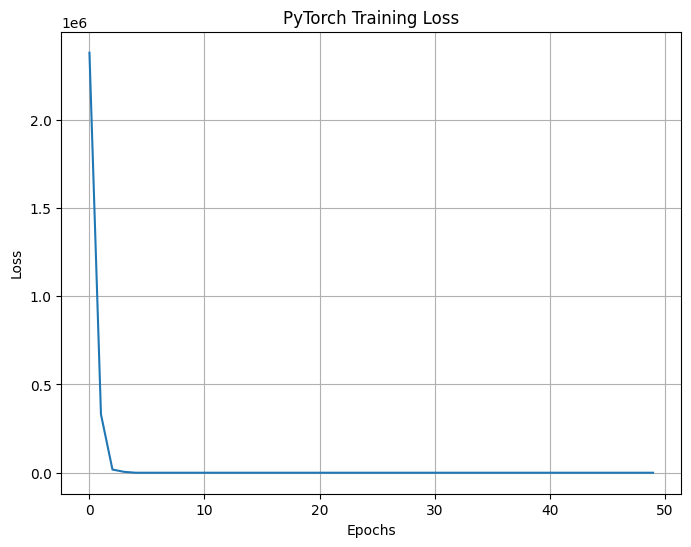

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(n_epochs), costs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('PyTorch Training Loss')
plt.grid(True)
plt.show()

In [17]:
# Print some of the data to verify
print("Number of labels:", len(labels_test))
print("Number of audio samples:", len(audio_test))

padded_audio_test = numpy_pad_sequences(
    audio_test,
    dtype='float32',
    maxlen=max_length,  # Use the maximum length
    padding='post',  # 'pre' or 'post'
)
print("Padded data shape:", padded_audio_test.shape)
audio_test = padded_audio_test

Number of labels: 74
Number of audio samples: 74
Padded data shape: (74, 95040)


In [18]:
# Move test data to device
test_tensor = torch.tensor(audio_test, dtype=torch.float32).to(device)

# Labels need to be encoded into numbers, using sklearn to do it (AI to develop AI lol)
y_test_encoded = label_encoder.transform(labels_test)
print(y_test_encoded)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long).to(device)

# Create a Dataset and DataLoader
test_dataset = TensorDataset(test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4]


In [ ]:
def evaluate(model, data_loader, device) -> float:
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            _, predicted_classes = torch.max(outputs, 1)  # Get class predictions
            correct_predictions += (predicted_classes == y_batch).sum().item()
            total_samples += y_batch.size(0)

    accuracy = correct_predictions / total_samples
    return accuracy

evaluate(pytorch_model, test_loader, device) # Crazy that it returns 1!!

1.0